# Data Cleaning and EDA of Freelancer Dataset

In [44]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import ast
from wordcloud import WordCloud

warnings.filterwarnings("ignore")
%matplotlib inline

## Load and Understanding The Dataset

This dataset contains over 9,193 data analysis job postings scraped from Freelancer.com, a leading freelance platform. The dataset provides valuable insights into the freelance data analysis market, including job titles, skills, rates, and client preferences.

**Columns:**
* projectId: This is a unique field use to uniquely identify each freelance project. It can be use to determine duplicate in the dataset.
* job_title: This is the job title offer by a client.
* job_description: This provides a description of the job.
* tags: 
* client_state: state from which a client is posting the job
* client_country: country from which a client is posting the job
* client_average_rating: client average rating on a job
* client_review_count: numbers of review on each job
* min_price: minimum price offer.
* max_price: maximum price offer.
* avg_price: average price offer.
* currency: money denomination
* rate_type: rating categories.

In [45]:
# load dataset
job_df = pd.read_csv('./freelancer_job_postings.csv')
job_df.head()

,projectId,job_title,job_description,tags,client_state,client_country,client_average_rating,client_review_count,min_price,max_price,avg_price,currency,rate_type
0,37426471,development and implementation of a federated ...,please bid only if you are ready to do the wor...,"['algorithm', 'java', 'python', 'machine learn...",Heilbronn,Germany,5.0,17,8.0,30.0,19.0,EUR,fixed
1,37421546,Data Entry -- 2,Project Title: Data Entry - Data Analysis in E...,"['excel', 'statistical analysis', 'statistics'...",Nagpur,India,0.0,0,750.0,1250.0,1000.0,INR,hourly
2,37400492,Data Scrap,I am looking for a freelancer who can help me ...,"['web scraping', 'data mining', 'data entry', ...",Eaubonne,France,5.0,1,30.0,250.0,140.0,EUR,fixed
3,37404568,Big Data Project,Store Sales Data Analysis: A Data Engineering ...,"['big data sales', 'data science', 'data minin...",Mundra,India,5.0,2,5000.0,5500.0,5250.0,INR,fixed
4,37397423,Virtual Assistant / Research Assistant,Job Description: I am seeking a Virtual Assist...,"['data entry', 'virtual assistant', 'web searc...",NaN,United States,0.0,0,5.0,15.0,10.0,USD,hourly


In [46]:
# display columns
job_df.columns

Index(['projectId', 'job_title', 'job_description', 'tags', 'client_state',
       'client_country', 'client_average_rating', 'client_review_count',
       'min_price', 'max_price', 'avg_price', 'currency', 'rate_type'],
      dtype='object')

In [47]:
# shape
job_df.shape

(9193, 13)

In [48]:
# info
job_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9193 entries, 0 to 9192
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   projectId              9193 non-null   int64  
 1   job_title              9193 non-null   object 
 2   job_description        9193 non-null   object 
 3   tags                   9193 non-null   object 
 4   client_state           8828 non-null   object 
 5   client_country         9192 non-null   object 
 6   client_average_rating  9193 non-null   float64
 7   client_review_count    9193 non-null   int64  
 8   min_price              9193 non-null   float64
 9   max_price              9193 non-null   float64
 10  avg_price              9193 non-null   float64
 11  currency               9193 non-null   object 
 12  rate_type              9193 non-null   object 
dtypes: float64(4), int64(2), object(7)
memory usage: 933.8+ KB


**From the dataset information above its obvious that the dataset contains `9,123` rows and `12` columns of data. Also the dataset some missing valuses 
in the `client_state` column.**

In [49]:
# check for duplicates
job_df.duplicated().sum()

0

**The Dataset doesn't contain any duplicate value. So we can drop the ProjectID column since it has no impact on our analysis**

In [50]:
# drop the projectId column
job_df.drop(columns=['projectId'],inplace=True)

## Data Transformation

**Dealing with the missing data**

In [51]:
# replace missing value in client_state with 'Unknown'
job_df['client_state'].fillna('Unknown', inplace=True)

In [52]:
# replace missing value in client_country with 'Unknown'
job_df['client_country'].fillna('Unknown', inplace=True)

**Dealing with Inconsistency data**
Taking a closer look at the text columns i discover that there maybe whitespaces and inconsistency in the type of casing use. if this is not taken
care of it may affect the unique nature of the data

**Examle:** <br/>
In the Job title we have 2 variety of Data Analysis

In [53]:
job_df['job_title'].value_counts()[0:10]

Data Analysis     47
Data analysis     32
data analysis     28
Data entry        27
Data analysis     25
Data entry        21
data entry        15
Data Entry        14
Data Analyst      11
data analyst      10
Name: job_title, dtype: int64

In [54]:
# now lets trim the job title
job_df['job_title'] = job_df['job_title'].str.strip()

# change casing
job_df['job_title'] = job_df['job_title'].str.title()

job_df['job_title'].value_counts()[0:10]

Data Analysis           149
Data Entry               89
Data Analyst             32
Data Analytics           27
Excel Data Analysis      23
Statistical Analysis     21
Python Project           17
Excel Expert             15
Data Science             13
Spss Analysis            12
Name: job_title, dtype: int64

**Coverting the currencies to USD**
Inorder to ensure data consistency in the dataset, we need to convert all different currency in the data set to a more uniform currency (USD).
To do this i used https://www.xe.com/ as a guide to determine the current convertion rate as at December 29, 2023.

In [55]:
# unique currency in the dataset
job_df['currency'].unique()

array(['EUR', 'INR', 'USD', 'SGD', 'GBP', 'AUD', 'HKD', 'CAD', 'NZD'],
      dtype=object)

In [56]:
convertion_rate = {
    'EUR': 1.10,
    'INR': 0.01,
    'USD': 1.00,
    'SGD': 0.002,
    'GBP': 1.27,
    'AUD': 0.68,
    'HKD': 0.13,
    'CAD': 0.76,
    'NZD': 0.63
}

# now convert each currency to USD
job_df['min_price (USD)'] = job_df.apply(lambda x: x['min_price'] * convertion_rate[x['currency']], axis=1)

job_df['max_price (USD)'] = job_df.apply(lambda x: x['max_price'] * convertion_rate[x['currency']], axis=1)

job_df['avg_price (USD)'] = job_df.apply(lambda x: x['avg_price'] * convertion_rate[x['currency']], axis=1)


In [57]:
job_df.head()

,job_title,job_description,tags,client_state,client_country,client_average_rating,client_review_count,min_price,max_price,avg_price,currency,rate_type,min_price (USD),max_price (USD),avg_price (USD)
0,Development And Implementation Of A Federated ...,please bid only if you are ready to do the wor...,"['algorithm', 'java', 'python', 'machine learn...",Heilbronn,Germany,5.0,17,8.0,30.0,19.0,EUR,fixed,8.8,33.0,20.9
1,Data Entry -- 2,Project Title: Data Entry - Data Analysis in E...,"['excel', 'statistical analysis', 'statistics'...",Nagpur,India,0.0,0,750.0,1250.0,1000.0,INR,hourly,7.5,12.5,10.0
2,Data Scrap,I am looking for a freelancer who can help me ...,"['web scraping', 'data mining', 'data entry', ...",Eaubonne,France,5.0,1,30.0,250.0,140.0,EUR,fixed,33.0,275.0,154.0
3,Big Data Project,Store Sales Data Analysis: A Data Engineering ...,"['big data sales', 'data science', 'data minin...",Mundra,India,5.0,2,5000.0,5500.0,5250.0,INR,fixed,50.0,55.0,52.5
4,Virtual Assistant / Research Assistant,Job Description: I am seeking a Virtual Assist...,"['data entry', 'virtual assistant', 'web searc...",Unknown,United States,0.0,0,5.0,15.0,10.0,USD,hourly,5.0,15.0,10.0


In [58]:
# now we can drop columns: min_price, max_price and avg_price
job_df.drop(columns=['min_price', 'max_price', 'avg_price'], inplace=True)

In [59]:
# check for missing value again
job_df.isnull().sum()

job_title                0
job_description          0
tags                     0
client_state             0
client_country           0
client_average_rating    0
client_review_count      0
currency                 0
rate_type                0
min_price (USD)          0
max_price (USD)          0
avg_price (USD)          0
dtype: int64

## Feature Engineering

For the sake of better analysis, it is neccessary to splits out the various tags associated to each project.

* Tags are in a list form, but considered as string column by Pandas
* so lets convert it to a List type

In [60]:
job_df['tags'] = job_df['tags'].apply(ast.literal_eval)

In [61]:
# now lets find out the count of tags by each project
job_df['tags'].apply(len).value_counts()

5     6144
4     1252
3      872
2      682
1      114
6       33
7       25
8       16
9        8
13       7
11       7
10       6
12       5
14       4
15       4
19       3
21       3
27       2
17       2
25       1
16       1
22       1
46       1
Name: tags, dtype: int64

A highest number of the projects have a maximum number of 5 tags. so i will filter this data into having less or 5 tags.

In [62]:
def trim_tag(tags):
    """
    trim the length of each tag to 5
    """
    if len(tags) == 5 or len(tags) < 5:
        return tags
    else:
        return tags[0:5]
        

In [63]:
# apply trim_tag function
job_df['tags'] = job_df['tags'].apply(trim_tag)

In [64]:
job_df.head()

,job_title,job_description,tags,client_state,client_country,client_average_rating,client_review_count,currency,rate_type,min_price (USD),max_price (USD),avg_price (USD)
0,Development And Implementation Of A Federated ...,please bid only if you are ready to do the wor...,"[algorithm, java, python, machine learning (ml...",Heilbronn,Germany,5.0,17,EUR,fixed,8.8,33.0,20.9
1,Data Entry -- 2,Project Title: Data Entry - Data Analysis in E...,"[excel, statistical analysis, statistics, spss...",Nagpur,India,0.0,0,INR,hourly,7.5,12.5,10.0
2,Data Scrap,I am looking for a freelancer who can help me ...,"[web scraping, data mining, data entry, excel,...",Eaubonne,France,5.0,1,EUR,fixed,33.0,275.0,154.0
3,Big Data Project,Store Sales Data Analysis: A Data Engineering ...,"[big data sales, data science, data mining, st...",Mundra,India,5.0,2,INR,fixed,50.0,55.0,52.5
4,Virtual Assistant / Research Assistant,Job Description: I am seeking a Virtual Assist...,"[data entry, virtual assistant, web search, ex...",Unknown,United States,0.0,0,USD,hourly,5.0,15.0,10.0


### Now lets split the tags into multiple columns

In [65]:
# Column names for the tags (five):
column_names = [f'tag_{i+1}' for i in range(5)]

list_of_tags = job_df['tags'].to_list()

tags_df = pd.DataFrame(list_of_tags, columns=column_names)
tags_df.head()

,tag_1,tag_2,tag_3,tag_4,tag_5
0,algorithm,java,python,machine learning (ml),flutter
1,excel,statistical analysis,statistics,spss statistics,data processing
2,web scraping,data mining,data entry,excel,web search
3,big data sales,data science,data mining,statistical analysis,analytics
4,data entry,virtual assistant,web search,excel,presentations


Before making the concatenation, I need to convert the tags from dtype NoneType to a 'Not Given':

In [66]:
tags_df = tags_df.applymap(lambda x: "Not Given" if x is None else x)
tags_df.head()

,tag_1,tag_2,tag_3,tag_4,tag_5
0,algorithm,java,python,machine learning (ml),flutter
1,excel,statistical analysis,statistics,spss statistics,data processing
2,web scraping,data mining,data entry,excel,web search
3,big data sales,data science,data mining,statistical analysis,analytics
4,data entry,virtual assistant,web search,excel,presentations


Now lets join both dataframe together


In [67]:
final_df = pd.concat([job_df, tags_df], axis=1, join='inner')
final_df.head()

,job_title,job_description,tags,client_state,client_country,client_average_rating,client_review_count,currency,rate_type,min_price (USD),max_price (USD),avg_price (USD),tag_1,tag_2,tag_3,tag_4,tag_5
0,Development And Implementation Of A Federated ...,please bid only if you are ready to do the wor...,"[algorithm, java, python, machine learning (ml...",Heilbronn,Germany,5.0,17,EUR,fixed,8.8,33.0,20.9,algorithm,java,python,machine learning (ml),flutter
1,Data Entry -- 2,Project Title: Data Entry - Data Analysis in E...,"[excel, statistical analysis, statistics, spss...",Nagpur,India,0.0,0,INR,hourly,7.5,12.5,10.0,excel,statistical analysis,statistics,spss statistics,data processing
2,Data Scrap,I am looking for a freelancer who can help me ...,"[web scraping, data mining, data entry, excel,...",Eaubonne,France,5.0,1,EUR,fixed,33.0,275.0,154.0,web scraping,data mining,data entry,excel,web search
3,Big Data Project,Store Sales Data Analysis: A Data Engineering ...,"[big data sales, data science, data mining, st...",Mundra,India,5.0,2,INR,fixed,50.0,55.0,52.5,big data sales,data science,data mining,statistical analysis,analytics
4,Virtual Assistant / Research Assistant,Job Description: I am seeking a Virtual Assist...,"[data entry, virtual assistant, web search, ex...",Unknown,United States,0.0,0,USD,hourly,5.0,15.0,10.0,data entry,virtual assistant,web search,excel,presentations


### Exploratory Data Analysis

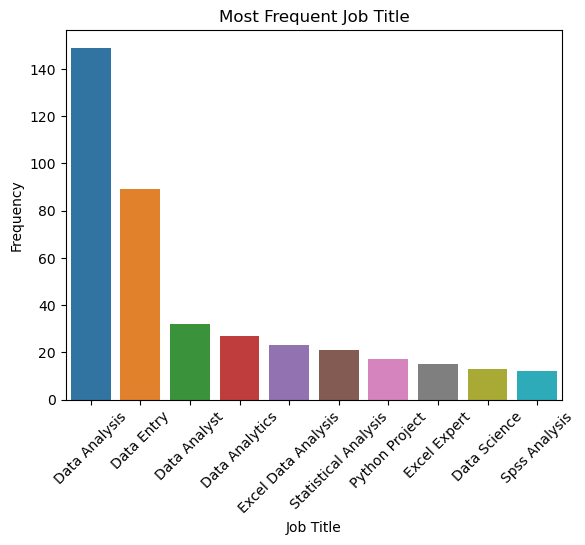

In [68]:
# most frequent job type
top_10_count = final_df['job_title'].value_counts()[0:10]
sns.barplot(x=top_10_count.index, y=top_10_count.values)
plt.title("Most Frequent Job Title")
plt.xlabel("Job Title")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

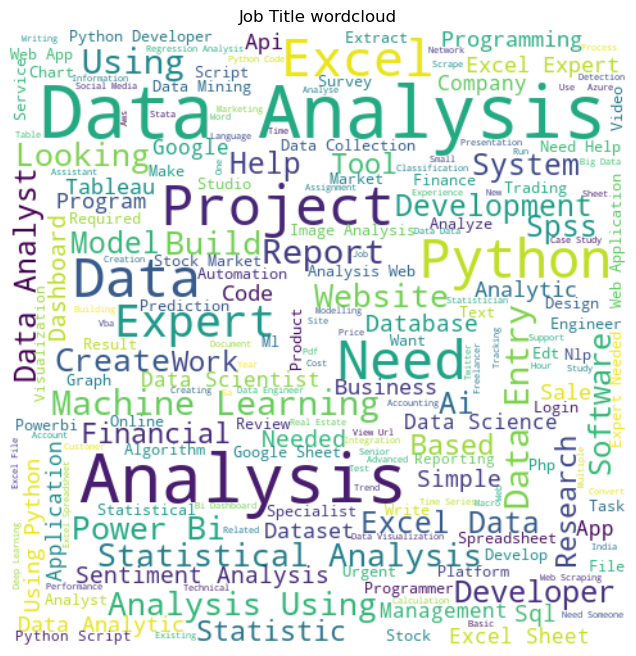

In [69]:
# create a list of words from the tags column
words = final_df['job_title']

# crete a wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0, background_color='white').generate(' '.join(words))

# plot the wordcloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.title('Job Title wordcloud')
plt.show()

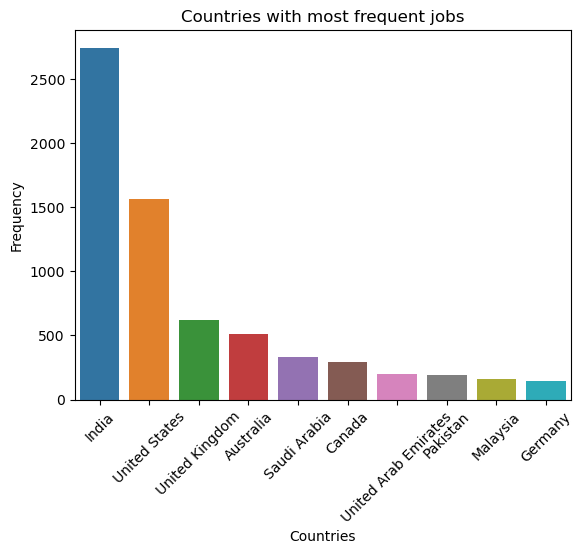

In [70]:
# Job Title by Country
top_10_country = final_df['job_title'].groupby(final_df['client_country']).count().sort_values(ascending=False)[0:10]
sns.barplot(x=top_10_country.index, y=top_10_country.values)
plt.title("Countries with most frequent jobs")
plt.xlabel("Countries")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

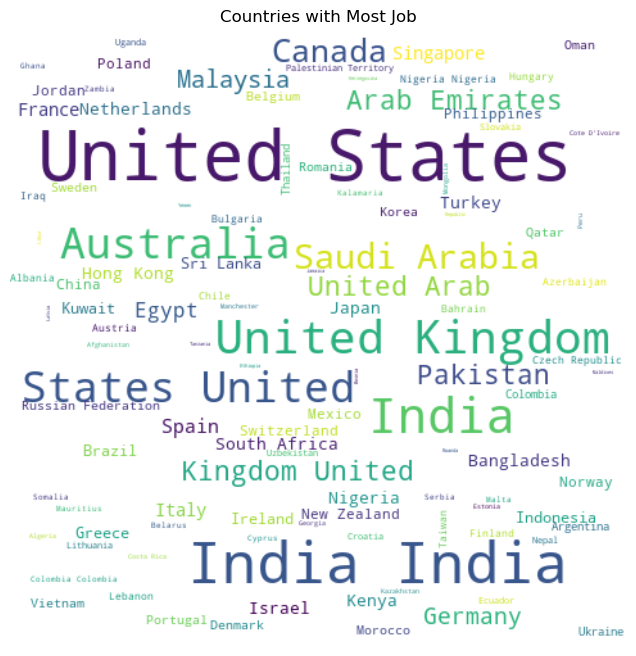

In [71]:
words = final_df['client_country']

# crete a wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0, background_color='white').generate(' '.join(words))

# plot the wordcloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.title('Countries with Most Job')
plt.show()

In [72]:
# I combined all values for all five tags per job post in a single column to count the values:
all_tags = pd.concat([tags_df['tag_1'], tags_df['tag_2'], tags_df['tag_3'], tags_df['tag_4'], tags_df['tag_5']]).reset_index(drop=True)

# Now I can count all values with just one code line:

all_tags.value_counts().head(30)


Not Given                 5498
excel                     3158
python                    3109
statistics                2365
data processing           2363
statistical analysis      2193
data entry                1432
data mining               1256
machine learning (ml)     1237
r programming language    1207
software architecture     1085
spss statistics           1055
data analysis              809
php                        772
mysql                      699
web scraping               532
data analytics             530
data science               519
business analysis          514
visual basic               503
sql                        487
mathematics                431
research                   375
javascript                 372
java                       369
finance                    350
research writing           324
accounting                 319
algorithm                  312
web search                 290
dtype: int64

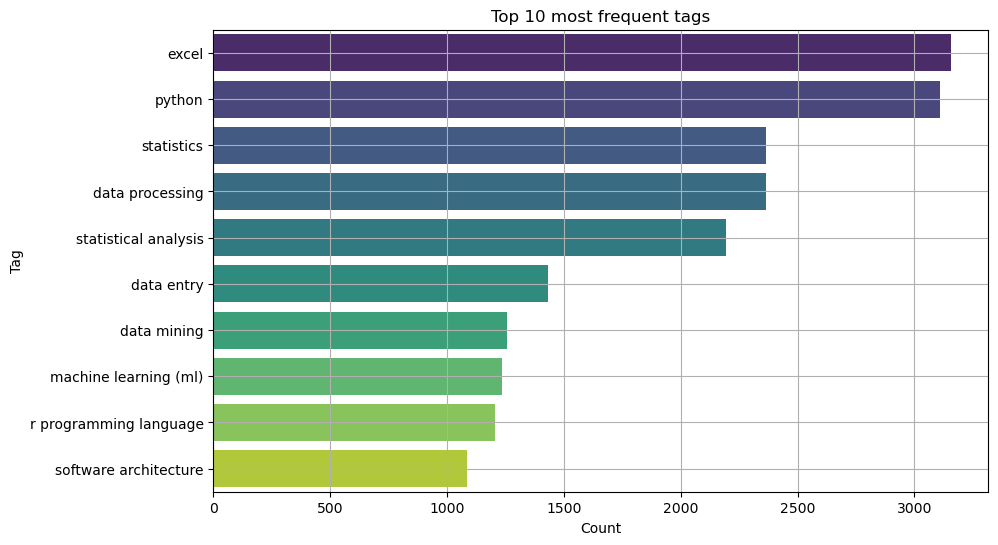

In [73]:
tag_counts = all_tags[all_tags != "Not Given"].value_counts()
# Visualización de las 10 habilidades más demandadas

plt.figure(figsize=(10, 6))
sns.barplot(x=tag_counts.head(10), y=tag_counts.head(10).index, palette='viridis')
plt.title('Top 10 most frequent tags')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.grid(True)
plt.show()